In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob


def calibrate_camera(images, nx=9, ny=6):             
    objpoints = []  # 3D points in real world space
    imgpoints = []  # 2D points in image plane
    
    # Prepare object points, like (0,0,0), (1,0,0), ..., (nx,ny,0)
    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)  # x, y coordinates
    
    for img_path in images:
        img = cv2.imread(img_path)
    
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
            
        if ret:
            imgpoints.append(corners)
            objpoints.append(objp)
            # cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            # plt.imshow(img)
        else:
            # TODO: why some images have no corners found???
            print('WARN: no corners was found for image: %s!!!' % img_path)
    
    return objpoints, imgpoints
    
    
def undistort_image(img, objpoints, imgpoints):    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undistorted_image = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted_image

WARN: no corners was found for image: camera_cal/calibration5.jpg!!!
WARN: no corners was found for image: camera_cal/calibration4.jpg!!!
WARN: no corners was found for image: camera_cal/calibration1.jpg!!!


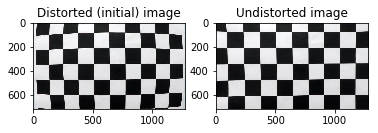

In [2]:
images = glob.glob('camera_cal/calibration*.jpg')
objpoints, imgpoints = calibrate_camera(images)

distorted_img = cv2.imread(images[6])
undistorted_img = undistort_image(distorted_img, objpoints, imgpoints)

fig, axs = plt.subplots(1, 2)
plt.rcParams['figure.figsize'] = 15, 15
subplot = axs[0]
subplot.set_title('Distorted (initial) image')
subplot.imshow(distorted_img)

subplot = axs[1]
subplot.set_title('Undistorted image')
subplot.imshow(undistorted_img)

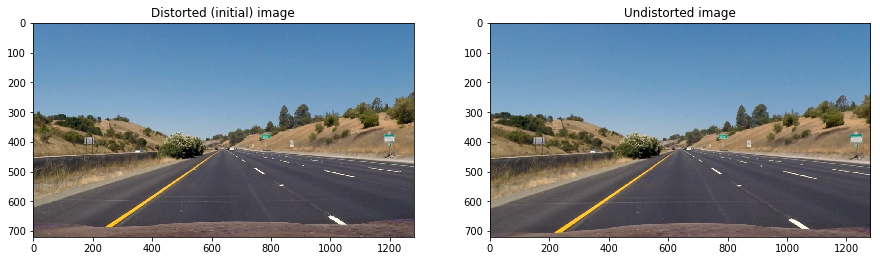

In [3]:
distorted_test_img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted_test_img = undistort_image(distorted_test_img, objpoints, imgpoints)

fig, axs = plt.subplots(1, 2)
plt.rcParams['figure.figsize'] = 15, 15
subplot = axs[0]
subplot.set_title('Distorted (initial) image')
subplot.imshow(distorted_test_img)

subplot = axs[1]
subplot.set_title('Undistorted image')
subplot.imshow(undistorted_test_img)

In [4]:
def perspective_transform(img):
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
def create_vertices(img):
    imshape = img.shape
    return np.array([[ 
        (.440*imshape[1], .65*imshape[0]), 
        (.200*imshape[1], .93*imshape[0]), 
        (.820*imshape[1], .93*imshape[0]),
        (.563*imshape[1], .65*imshape[0])]], dtype=np.int32)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def print_vertice(image, ver1, ver2):
    cv2.line(image, (int(ver1[0]), int(ver1[1])), (int(ver2[0]), int(ver2[1])), [255, 0, 0], 2)
    
def show_region_of_interest(image, vertices):
    print_vertice(image, vertices[0][0], vertices[0][1])
    print_vertice(image, vertices[0][1], vertices[0][2])
    print_vertice(image, vertices[0][2], vertices[0][3])
    print_vertice(image, vertices[0][3], vertices[0][0])

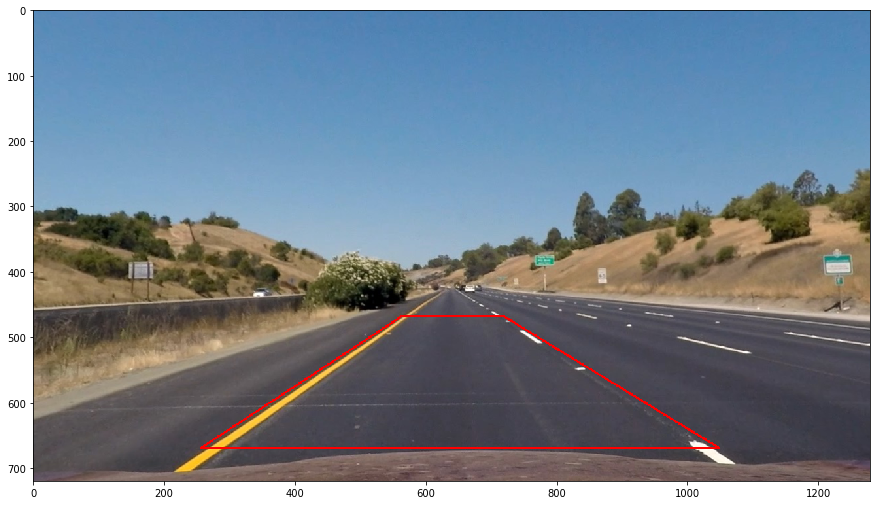

In [5]:
vertices = create_vertices(undistorted_test_img)
#masked_edges = region_of_interest(edges_img, vertices)
show_region_of_interest(undistorted_test_img, vertices)
plt.imshow(undistorted_test_img)

In [6]:
points = vertices[0]
src = np.float32(points)
print("src coordinates: \n", src)

dest = np.float32(
     [[points[1][0], 200],
      points[1],
      points[2],
     [points[2][0], 200]]
)
print("dest coordinates: \n", dest)

src coordinates: 
 [[  563.   468.]
 [  256.   669.]
 [ 1049.   669.]
 [  720.   468.]]
dest coordinates: 
 [[  256.   200.]
 [  256.   669.]
 [ 1049.   669.]
 [ 1049.   200.]]


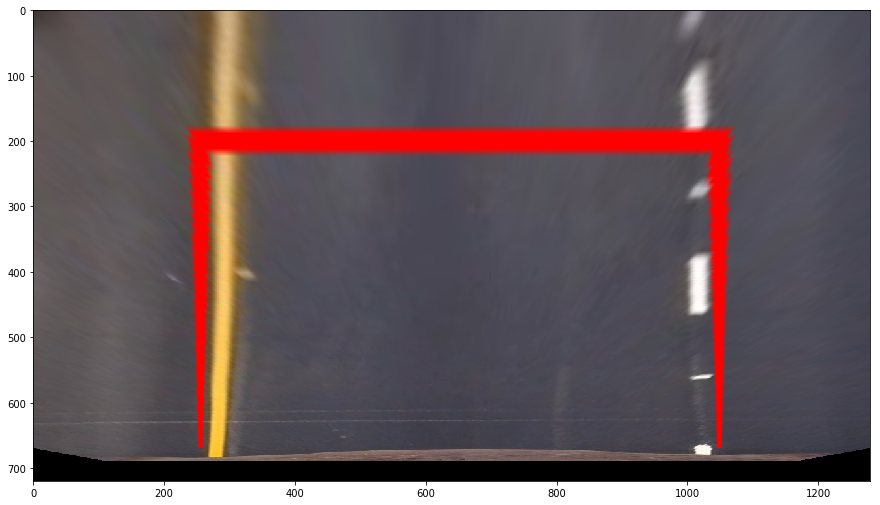

In [7]:
M = cv2.getPerspectiveTransform(src, dest)
img_size = (undistorted_test_img.shape[1], undistorted_test_img.shape[0])
warped = cv2.warpPerspective(undistorted_test_img, M, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(warped)

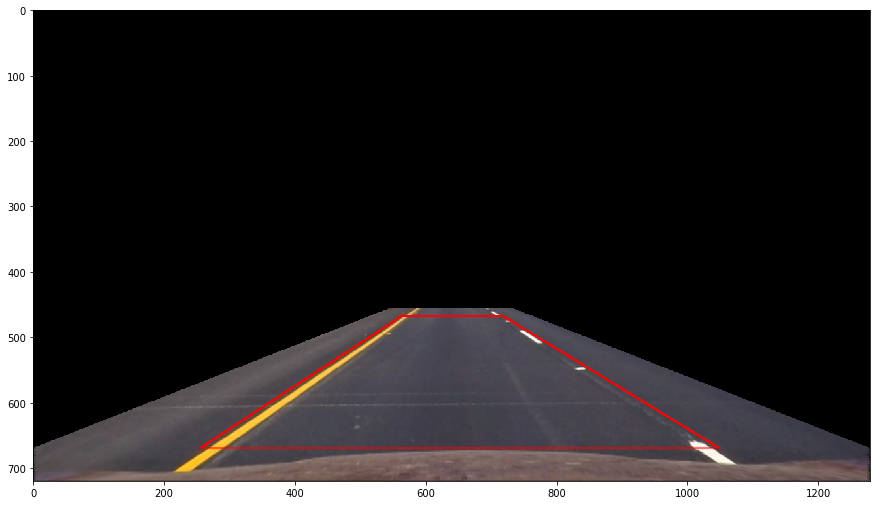

In [8]:
Minv = cv2.getPerspectiveTransform(dest, src)
unwarped = cv2.warpPerspective(warped, Minv, img_size, flags=cv2.INTER_LINEAR)
plt.imshow(unwarped)

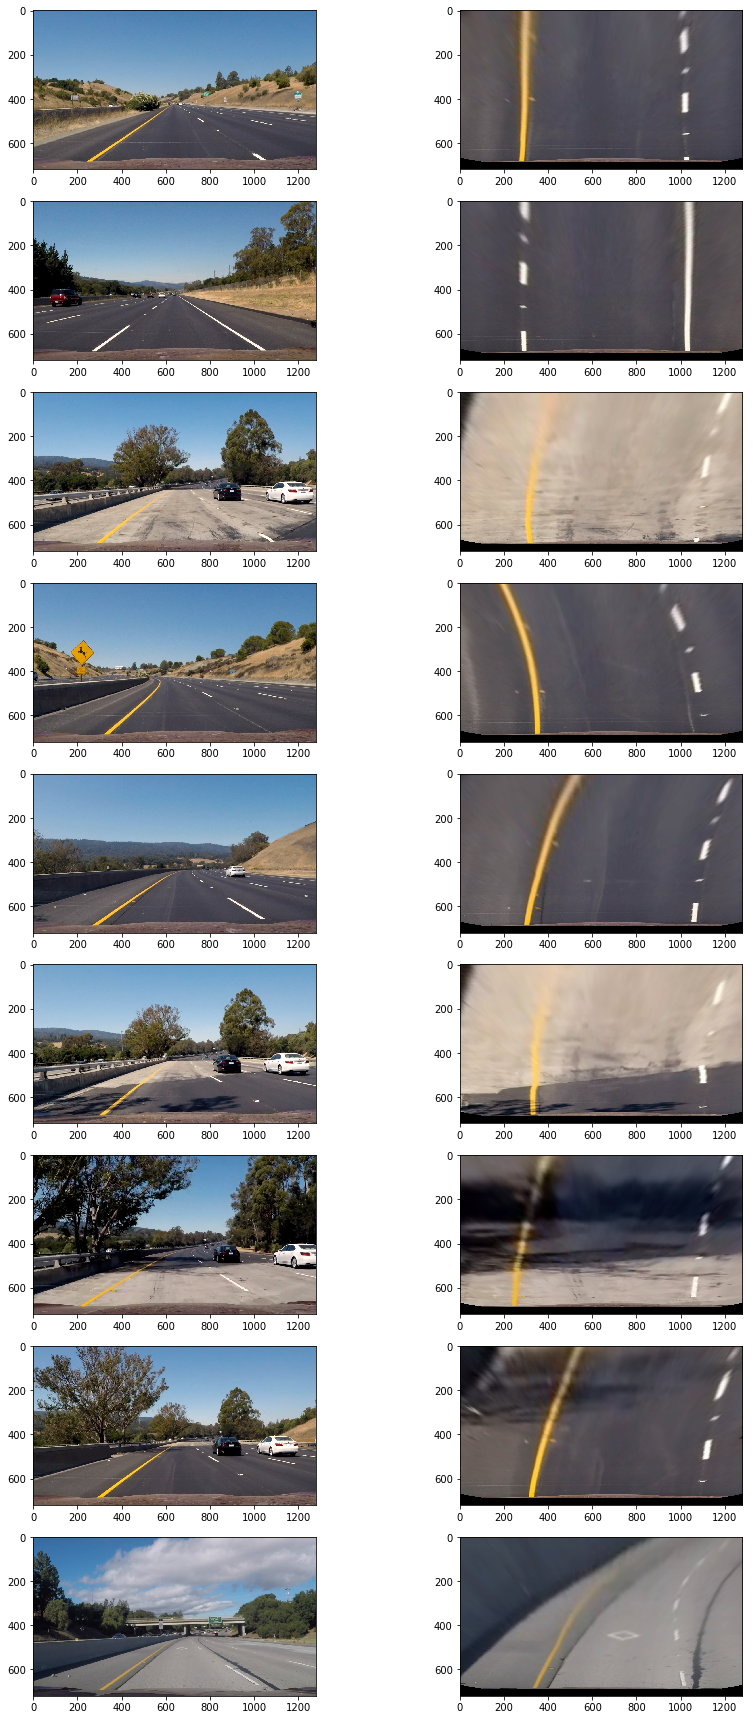

In [9]:
# Test on all test images
list_of_images = ['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 
                  'test4.jpg', 'test5.jpg', 'test6.jpg', 'challenge1.jpg']

columns = 2
rows = len(list_of_images)

fig, axs = plt.subplots(rows, columns, figsize=(12, 24))
fig.tight_layout()

for index, img_name in enumerate(list_of_images):
    orig_img = mpimg.imread('test_images/' + img_name)
    axs[index, 0].imshow(orig_img)
    
    undistorted_img = undistort_image(orig_img, objpoints, imgpoints)
    warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
    axs[index, 1].imshow(warped_img)

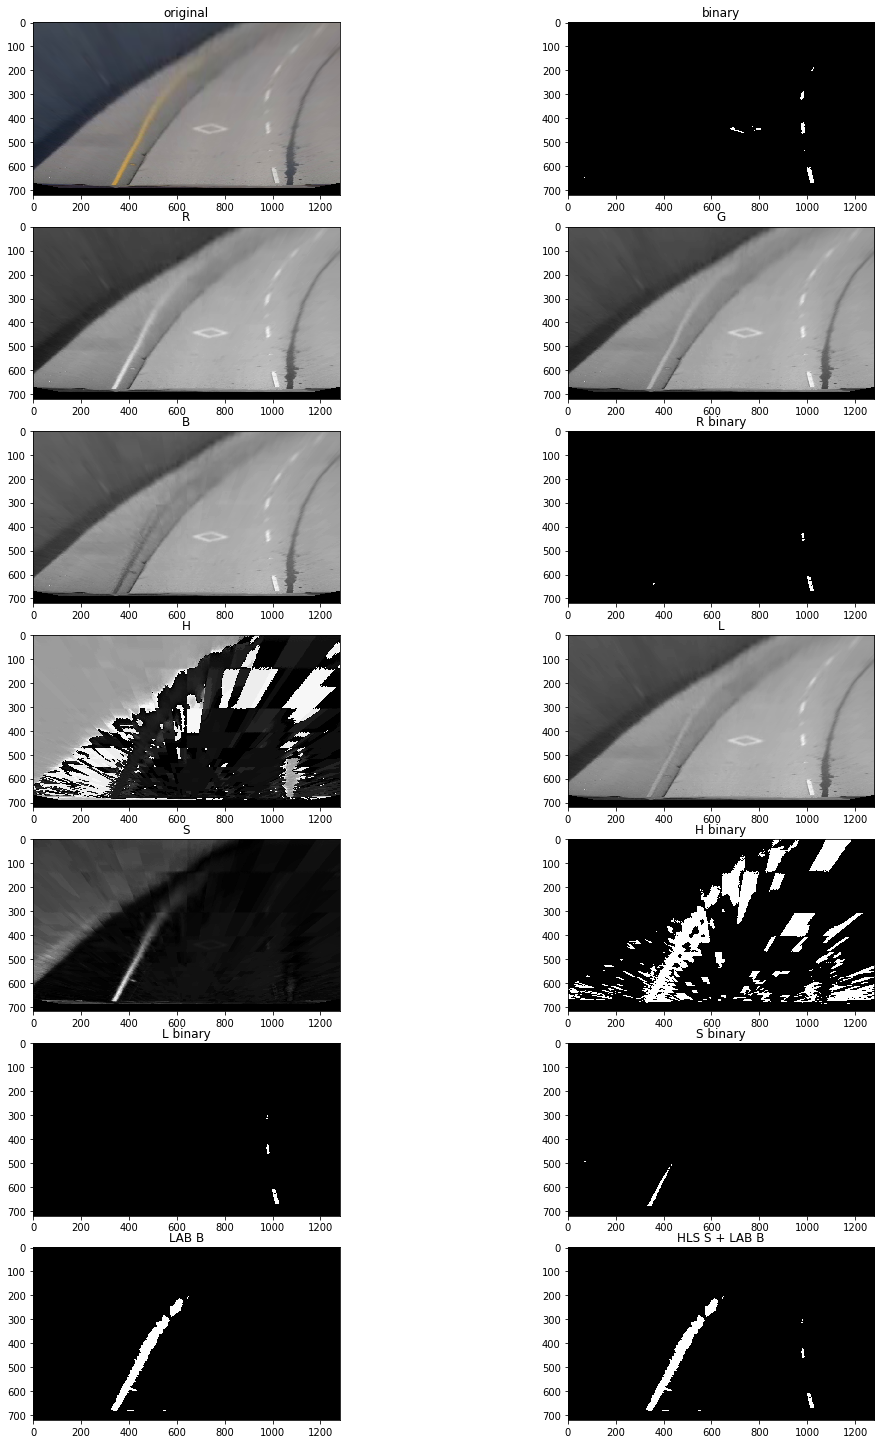

In [10]:
challenge_img = mpimg.imread('test_images/challenge1.jpg')
img_size = (orig_img.shape[1], orig_img.shape[0])
challenge_img = cv2.warpPerspective(challenge_img, M, img_size, flags=cv2.INTER_LINEAR)

fig, axs = plt.subplots(7, 2, figsize=(15, 20))
fig.tight_layout()
axs[0][0].set_title('original')
axs[0][0].imshow(challenge_img)

def binary_thres(img, thresh=(180, 255)):
    gray = cv2.cvtColor(challenge_img, cv2.COLOR_RGB2GRAY)
    binary = np.zeros_like(gray)
    binary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
    return binary

axs[0][1].set_title('binary')
axs[0][1].imshow(binary_thres(challenge_img), cmap='gray')

# RGB
R = challenge_img[:,:,0]
G = challenge_img[:,:,1]
B = challenge_img[:,:,2]
axs[1][0].set_title('R')
axs[1][0].imshow(R, cmap='gray')
axs[1][1].set_title('G')
axs[1][1].imshow(G, cmap='gray')
axs[2][0].set_title('B')
axs[2][0].imshow(B, cmap='gray')

thresh = (200, 255)
binary = np.zeros_like(R)
binary[(R > thresh[0]) & (R <= thresh[1])] = 1
axs[2][1].set_title('R binary')
axs[2][1].imshow(binary, cmap='gray')

hls = cv2.cvtColor(challenge_img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
axs[3][0].set_title('H')
axs[3][0].imshow(H, cmap='gray')
axs[3][1].set_title('L')
axs[3][1].imshow(L, cmap='gray')
axs[4][0].set_title('S')
axs[4][0].imshow(S, cmap='gray')

thresh = (15, 100)
binary = np.zeros_like(H)
binary[(H > thresh[0]) & (H <= thresh[1])] = 1
axs[4][1].set_title('H binary')
axs[4][1].imshow(binary, cmap='gray')

def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

axs[5][0].set_title('L binary')
hls_l = hls_lthresh(challenge_img)
axs[5][0].imshow(hls_l, cmap='gray')

thresh = (90, 255)
binary = np.zeros_like(S)
binary[(S > thresh[0]) & (S <= thresh[1])] = 1
axs[5][1].set_title('S binary')
axs[5][1].imshow(binary, cmap='gray')

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

axs[6][0].set_title('LAB B')
lab_b = lab_bthresh(challenge_img)
axs[6][0].imshow(lab_b, cmap='gray')

combined = np.zeros_like(lab_b)
combined[(hls_l == 1) | (lab_b == 1)] = 1
axs[6][1].set_title('HLS S + LAB B')
axs[6][1].imshow(combined, cmap='gray')

In [11]:
def pipeline(img):
    img = np.copy(img)
    
    hls_l = hls_lthresh(img)
    lab_b = lab_bthresh(img)
    combined = np.zeros_like(lab_b, dtype=np.uint8)
    combined[(hls_l == 1) | (lab_b == 1)] = 1
    
    return combined

def pipeline_(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return combined_binary

def binary_warped(orig_img, objpoints, imgpoints, M):
    undistorted_img = undistort_image(orig_img, objpoints, imgpoints)
    img_size = (orig_img.shape[1], orig_img.shape[0])
    warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
    binary_warped_img = pipeline(warped_img)
    return binary_warped_img

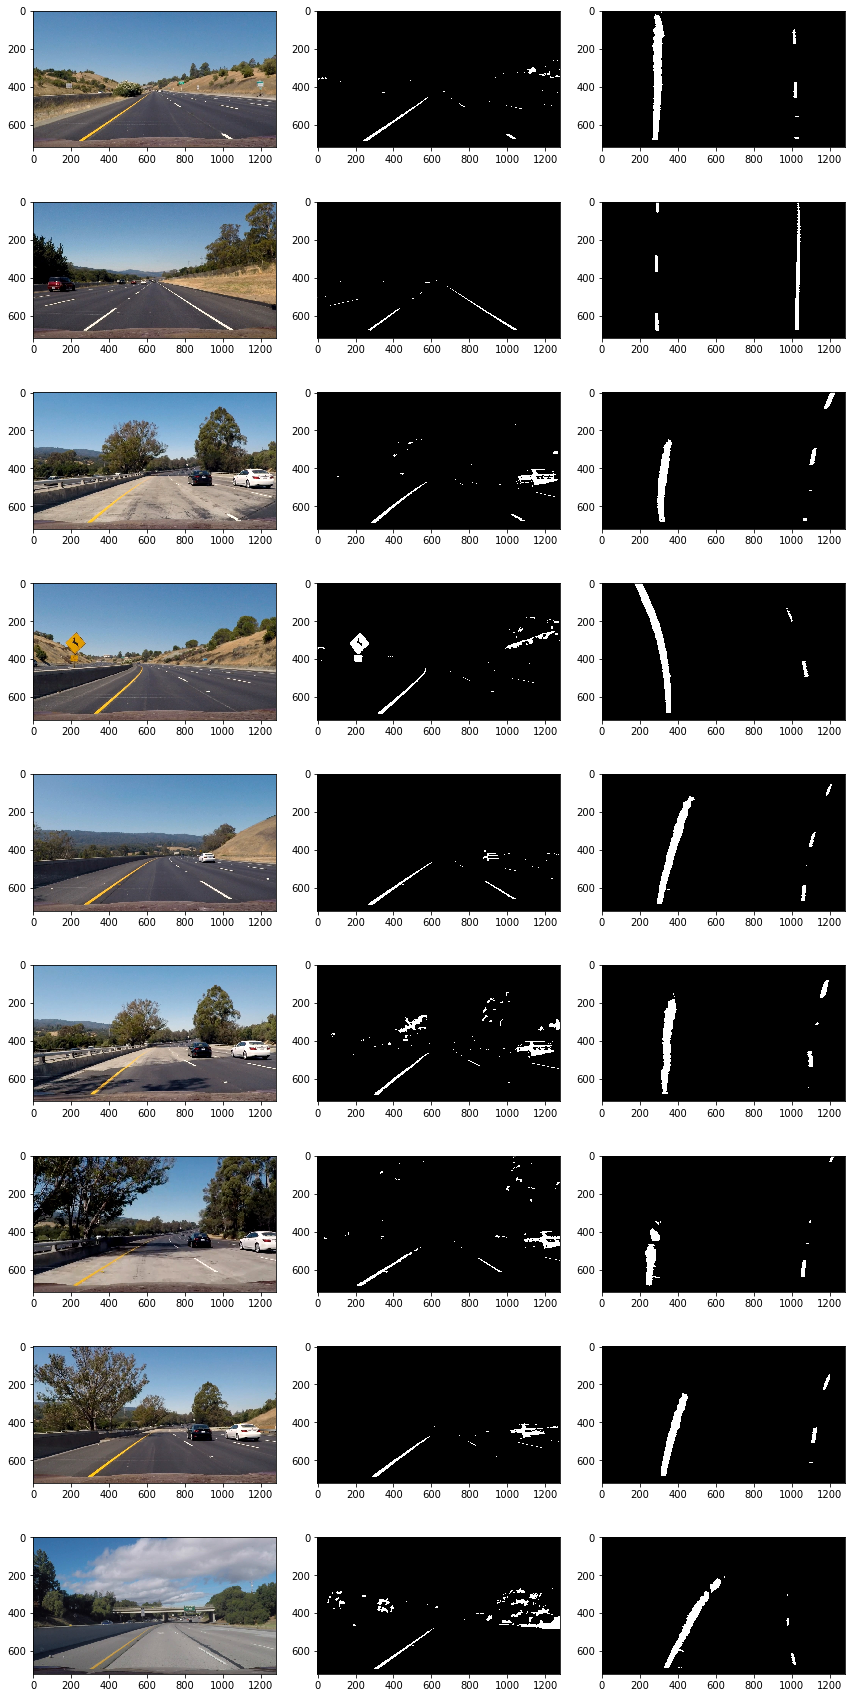

In [12]:
fig, axs = plt.subplots(rows, 3, figsize=(12, 24))
fig.tight_layout()

for index, img_name in enumerate(list_of_images):
    orig_img = mpimg.imread('test_images/' + img_name)
    axs[index, 0].imshow(orig_img)
    
    result_img = pipeline(orig_img)
    axs[index, 1].imshow(result_img, cmap='gray')
    
    warped_pipe_img = binary_warped(orig_img, objpoints, imgpoints, M)
    axs[index, 2].imshow(warped_pipe_img, cmap='gray')


## 5. Finding lines

In [79]:
from scipy.signal import savgol_filter

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # last n fits count used to smoothe line
        self.smoothing_window = 51
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
        # For visualizations
        self.search_windows = []
        self.search_margin = None
        
        self.best_fit_history = []
             
    def fit(self, ploty):
        # Polyfit line
        self.current_fit.append(np.polyfit(self.ally, self.allx, 2))

        # best fit
        if len(self.current_fit) < self.smoothing_window:
            ## Not enough history, just take last one
            self.best_fit = self.current_fit[-1]
        else:
            # Resize history
            #self.current_fit = self.current_fit[-self.history_size:]
            # Use savgol filter to smooth
            #print(self.current_fit)
            smoothed_fit = savgol_filter(self.current_fit, self.smoothing_window, 3, axis=0)
            self.best_fit = smoothed_fit[-1]
            
        self.best_fit_history.append(self.best_fit)            
        self.bestx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
        self.detected = True    
    

In [35]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0) 
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    left_windows = []
    right_windows = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Store windows for visualization
        left_windows.append([(win_xleft_low,win_y_low), (win_xleft_high,win_y_high)])
        right_windows.append([(win_xright_low,win_y_low), (win_xright_high,win_y_high)])
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, left_windows, right_windows


def fit_polynomial(binary_warped, left_line, right_line):
    # Find our lane pixels first
    left_line.allx, left_line.ally, right_line.allx, right_line.ally, left_windows, right_windows = find_lane_pixels(binary_warped)
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    if len(left_line.allx) > 0 and len(right_line.allx) > 0:
        left_line.fit(ploty)
        right_line.fit(ploty)

    left_line.search_windows = left_windows
    right_line.search_windows = right_windows
    left_line.search_margin = None
    right_line.search_margin = None
        
    return left_line, right_line, ploty

In [15]:
def visualize_sliding_windows(binary_warped_img, left_line, right_line):
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))
        
    # Draw the windows on the visualization image
    for window in left_line.search_windows:
        cv2.rectangle(out_img, window[0], window[1],(0,255,0), 2) 
        
    for window in right_line.search_windows:
        cv2.rectangle(out_img, window[0], window[1],(0,255,0), 2) 
    
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]
    
    left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))], np.int32)
    cv2.polylines(out_img,[left],False,(255,255, 0), thickness = 2)
    
    right = np.array([np.transpose(np.vstack([right_line.bestx, ploty]))], np.int32)
    cv2.polylines(out_img,[right],False,(255,255, 0), thickness = 2)

    return out_img

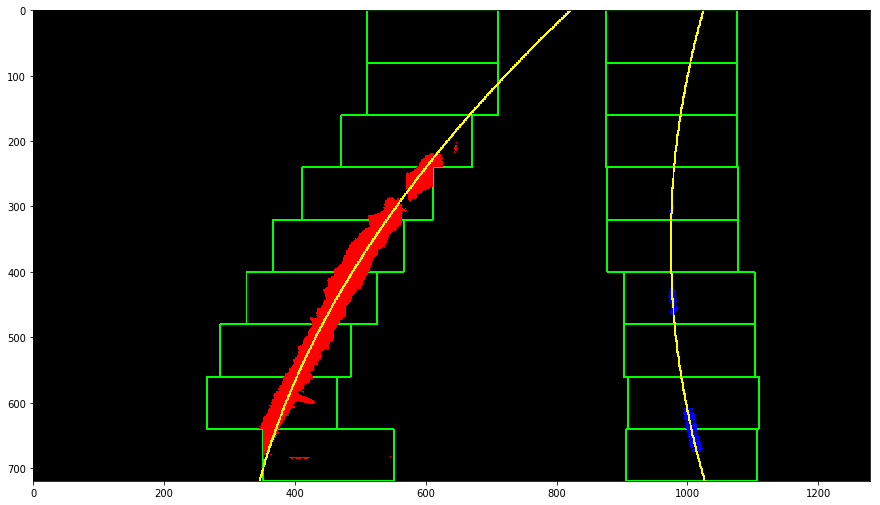

In [16]:
# Load our image and visualize sliding windows with fit line
orig_img = mpimg.imread('test_images/challenge1.jpg')
binary_warped_img = binary_warped(orig_img, objpoints, imgpoints, M)

left_line = Line()
right_line = Line()
left_line, right_line, ploty = fit_polynomial(binary_warped_img, left_line, right_line)
viz_img = visualize_sliding_windows(binary_warped_img, left_line, right_line)
plt.imshow(viz_img)

In [17]:
## SEARCH FROM PRIOR
def search_around_poly(binary_warped, left_line, right_line):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_line.best_fit[0]*(nonzeroy**2) + left_line.best_fit[1]*nonzeroy + 
                    left_line.best_fit[2] - margin)) & (nonzerox < (left_line.best_fit[0]*(nonzeroy**2) + 
                    left_line.best_fit[1]*nonzeroy + left_line.best_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_line.best_fit[0]*(nonzeroy**2) + right_line.best_fit[1]*nonzeroy + 
                    right_line.best_fit[2] - margin)) & (nonzerox < (right_line.best_fit[0]*(nonzeroy**2) + 
                    right_line.best_fit[1]*nonzeroy + right_line.best_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    left_line.allx = nonzerox[left_lane_inds]
    left_line.ally = nonzeroy[left_lane_inds] 
    right_line.allx = nonzerox[right_lane_inds]
    right_line.ally = nonzeroy[right_lane_inds]
    
    if len(left_line.allx) > 0 and len(right_line.allx) > 0:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_line.fit(ploty)
        right_line.fit(ploty)
        
    left_line.search_windows = None
    right_line.search_windows = None
    left_line.search_margin = margin
    right_line.search_margin = margin
    
    return ploty

In [18]:
def visualize_search_around(binary_warped_img, left_line, right_line):    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped_img, binary_warped_img, binary_warped_img))*255
    window_img = np.zeros_like(out_img)
    
    # Grab activated pixels
    nonzero = binary_warped_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Color in left and right line pixels
    out_img[left_line.ally, left_line.allx] = [255, 0, 0]
    out_img[right_line.ally, right_line.allx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_line.bestx-left_line.search_margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_line.bestx+left_line.search_margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_line.bestx-right_line.search_margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx+right_line.search_margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))], np.int32)
    cv2.polylines(result,[left],False,(255,255, 0), thickness = 2)
    
    right = np.array([np.transpose(np.vstack([right_line.bestx, ploty]))], np.int32)
    cv2.polylines(result,[right],False,(255,255, 0), thickness = 2)
    
    return result

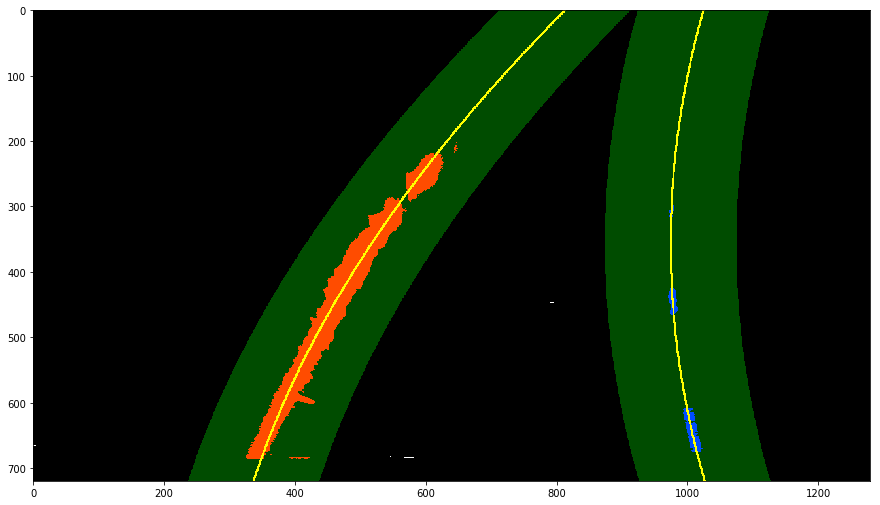

In [19]:
ploty = search_around_poly(binary_warped_img, left_line, right_line)
viz_img = visualize_search_around(binary_warped_img, left_line, right_line)
plt.imshow(viz_img)


## 6. Curvature

In [20]:
def calculate_r_curve(line, y_eval):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    #xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    return ((1 + (2*line.current_fit[0]*y_eval*ym_per_pix + line.current_fit[1])**2)**1.5) / np.absolute(2*line.current_fit[0])

def measure_curvature_pixels(ploty, left_line, right_line):
    '''
    Calculates the curvature of polynomial functions in pixels.
    '''
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = calculate_r_curve(left_line, y_eval)
    right_curverad = calculate_r_curve(right_line, y_eval)
    
    return left_curverad, right_curverad

#left_curv, right_curv = measure_curvature_pixels(ploty, left_line, right_line)
#print("Left curvature: ", left_curv)
#print("Right curvature: ", right_curv)

## 7. Draw lines

In [21]:
from moviepy.editor import VideoFileClip
from moviepy.video.io.bindings import mplfig_to_npimage
from IPython.display import HTML

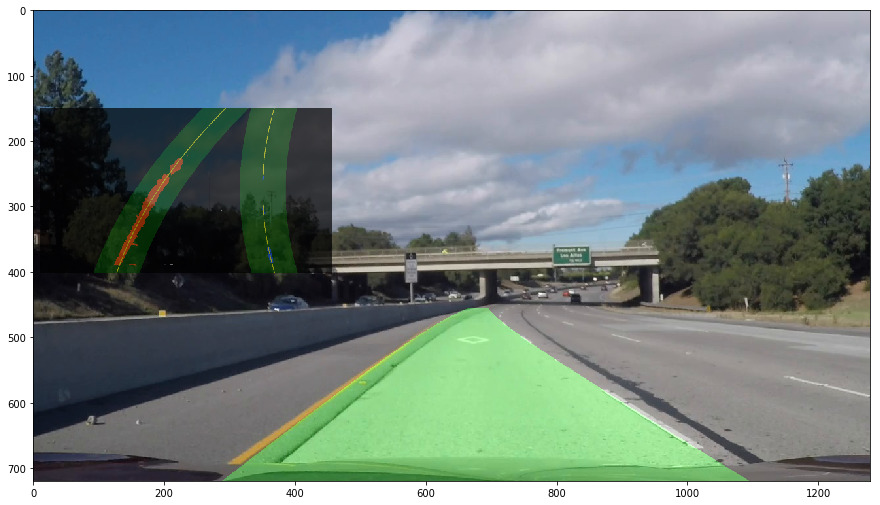

In [22]:
def add_curvature(img, left_line, right_line):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_curv, right_curv = measure_curvature_pixels(ploty, left_line, right_line)
    
    x_max = orig_img.shape[1]*xm_per_pix
    y_max = orig_img.shape[0]*ym_per_pix
    
    line_left = left_line.current_fit[0]*y_max**2 + left_line.current_fit[1]*y_max + left_line.current_fit[2]
    line_right = right_line.current_fit[0]*y_max**2 + right_line.current_fit[1]*y_max + right_line.current_fit[2]
    line_middle = line_left + (line_right - line_left)/2
    
    vehicle_center = x_max / 2
    diff = line_middle - vehicle_center
    
    cv2.putText(img, 'Left curvature: {} m'.format(int(left_curv)),(10,30), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img, 'Right curvature: {} m'.format(int(right_curv)),(10,60), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img, 'From center: {} m'.format(diff), (10,90), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),2,cv2.LINE_AA)

def add_heuristics(target_img, binary_warped_img, left_line, right_line):
    if left_line.search_margin == None:
        viz_img = visualize_sliding_windows(binary_warped_img, left_line, right_line)
        
    else:
        viz_img = visualize_search_around(binary_warped_img, left_line, right_line)
        
    small_viz_img = cv2.resize(viz_img, (0,0), fx=0.35, fy=0.35)
    rows,cols,channels = small_viz_img.shape
    positionx = 10
    positiony = 150
    overlay = cv2.addWeighted(target_img[positiony:positiony+rows, positionx:positionx+cols], 0.3, small_viz_img, 0.5, 0)
    target_img[positiony:positiony+rows, positionx:positionx+cols ] = overlay
    
def draw_lines(orig_img, binary_warped_img, left_line, right_line, ploty, draw_heuristics=True, draw_lines=True): 

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (orig_img.shape[1], orig_img.shape[0])) 
    # Combine the result with the original image
    if draw_lines:
        result = cv2.addWeighted(orig_img, 1, newwarp, 0.3, 0)
    else:
        result = orig_img
    
    if draw_heuristics:
        #add_curvature(result, left_line, right_line)
        add_heuristics(result, binary_warped_img, left_line, right_line)
    return result

img_with_lines = draw_lines(orig_img, binary_warped_img, left_line, right_line, ploty, True, True)
plt.imshow(img_with_lines)

## Video

In [23]:
from scipy.signal import savgol_filter

class LaneFinder():
    def __init__(self):
        self.right_line = Line()
        self.left_line = Line()
        self.draw_heuristics = True
        self.draw_lines = True
    
    def process_image(self, orig_img):
        #undistorted_img = undistort_image(orig_img, objpoints, imgpoints)
        undistorted_img = orig_img
        warped_img = cv2.warpPerspective(undistorted_img, M, img_size, flags=cv2.INTER_LINEAR)
        binary_warped_img = pipeline(warped_img)

        if self.left_line.detected == True and self.right_line.detected == True:
            try:
                ploty = search_around_poly(binary_warped_img, self.left_line, self.right_line)
            except:
                # searching with prior failed, force full search
                self.left_line.detected = False
                self.right_line.detected = False
        
        if self.left_line.detected == False or self.right_line.detected == False:
            try:
                self.left_line, self.right_line, ploty = fit_polynomial(binary_warped_img, self.left_line, self.right_line)
            except:
                self.left_line.detected = False
                self.right_line.detected = False
                return orig_img
            
        img_with_lines = draw_lines(orig_img, binary_warped_img, self.left_line, self.right_line, ploty, self.draw_heuristics, self.draw_lines)
        return img_with_lines
    
    def process_frame_callback(self):
        return lambda img: self.process_image(img)

In [107]:
inputVideoClip = VideoFileClip('project_video.mp4')
outputVideoName = 'project_video_output.mp4'

laneFinder = LaneFinder()
laneFinder.left_line.smoothing_window = 51
laneFinder.right_line.smoothing_window = 51
outputVideoClip = inputVideoClip.fl_image(laneFinder.process_frame_callback())
%time outputVideoClip.write_videofile(outputVideoName, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4








  0%|          | 0/1261 [00:00<?, ?it/s]





  0%|          | 2/1261 [00:00<01:53, 11.05it/s]





  0%|          | 4/1261 [00:00<01:51, 11.24it/s]





  0%|          | 6/1261 [00:00<01:50, 11.33it/s]





  1%|          | 8/1261 [00:00<01:49, 11.40it/s]





  1%|          | 10/1261 [00:00<01:49, 11.44it/s]





  1%|          | 12/1261 [00:01<01:49, 11.42it/s]





  1%|          | 14/1261 [00:01<01:49, 11.40it/s]





  1%|▏         | 16/1261 [00:01<01:50, 11.27it/s]





  1%|▏         | 18/1261 [00:01<01:50, 11.24it/s]





  2%|▏         | 20/1261 [00:01<01:50, 11.22it/s]





  2%|▏         | 22/1261 [00:01<01:51, 11.07it/s]





  2%|▏         | 24/1261 [00:02<01:52, 10.95it/s]





  2%|▏         | 26/1261 [00:02<01:53, 10.90it/s]





  2%|▏         | 28/1261 [00:02<01:53, 10.84it/s]





  2%|▏         | 30/1261 [00:02<01:53, 10.80it/s]





  3%|▎         | 32/1261 [00:02<01:53, 10.81it/s]





  3%|▎         | 34/1261 [00:03<01:53, 10.80it/s]





  3%|▎         | 

 10%|█         | 132/1261 [00:15<02:12,  8.49it/s]





 11%|█         | 133/1261 [00:15<02:12,  8.48it/s]





 11%|█         | 134/1261 [00:15<02:13,  8.47it/s]





 11%|█         | 135/1261 [00:15<02:12,  8.47it/s]





 11%|█         | 136/1261 [00:16<02:13,  8.46it/s]





 11%|█         | 137/1261 [00:16<02:13,  8.45it/s]





 11%|█         | 138/1261 [00:16<02:13,  8.43it/s]





 11%|█         | 139/1261 [00:16<02:13,  8.43it/s]





 11%|█         | 140/1261 [00:16<02:12,  8.43it/s]





 11%|█         | 141/1261 [00:16<02:13,  8.41it/s]





 11%|█▏        | 142/1261 [00:16<02:13,  8.41it/s]





 11%|█▏        | 143/1261 [00:17<02:12,  8.41it/s]





 11%|█▏        | 144/1261 [00:17<02:12,  8.41it/s]





 11%|█▏        | 145/1261 [00:17<02:12,  8.40it/s]





 12%|█▏        | 146/1261 [00:17<02:12,  8.40it/s]





 12%|█▏        | 147/1261 [00:17<02:12,  8.39it/s]





 12%|█▏        | 148/1261 [00:17<02:12,  8.39it/s]





 12%|█▏        | 149/1261 [00:17<02:12,  8.38it/

 19%|█▉        | 242/1261 [00:29<02:04,  8.17it/s]





 19%|█▉        | 243/1261 [00:29<02:04,  8.17it/s]





 19%|█▉        | 244/1261 [00:29<02:04,  8.18it/s]





 19%|█▉        | 245/1261 [00:29<02:04,  8.18it/s]





 20%|█▉        | 246/1261 [00:30<02:04,  8.18it/s]





 20%|█▉        | 247/1261 [00:30<02:04,  8.17it/s]





 20%|█▉        | 248/1261 [00:30<02:04,  8.16it/s]





 20%|█▉        | 249/1261 [00:30<02:04,  8.16it/s]





 20%|█▉        | 250/1261 [00:30<02:03,  8.16it/s]





 20%|█▉        | 251/1261 [00:30<02:03,  8.16it/s]





 20%|█▉        | 252/1261 [00:30<02:03,  8.16it/s]





 20%|██        | 253/1261 [00:31<02:03,  8.16it/s]





 20%|██        | 254/1261 [00:31<02:03,  8.16it/s]





 20%|██        | 255/1261 [00:31<02:03,  8.16it/s]





 20%|██        | 256/1261 [00:31<02:03,  8.16it/s]





 20%|██        | 257/1261 [00:31<02:03,  8.16it/s]





 20%|██        | 258/1261 [00:31<02:02,  8.16it/s]





 21%|██        | 259/1261 [00:31<02:02,  8.16it/

 28%|██▊       | 352/1261 [00:43<01:53,  8.03it/s]





 28%|██▊       | 353/1261 [00:44<01:53,  8.02it/s]





 28%|██▊       | 354/1261 [00:44<01:53,  8.01it/s]





 28%|██▊       | 355/1261 [00:44<01:53,  8.01it/s]





 28%|██▊       | 356/1261 [00:44<01:52,  8.01it/s]





 28%|██▊       | 357/1261 [00:44<01:52,  8.01it/s]





 28%|██▊       | 358/1261 [00:44<01:52,  8.00it/s]





 28%|██▊       | 359/1261 [00:44<01:52,  8.01it/s]





 29%|██▊       | 360/1261 [00:44<01:52,  8.01it/s]





 29%|██▊       | 361/1261 [00:45<01:52,  8.01it/s]





 29%|██▊       | 362/1261 [00:45<01:52,  8.01it/s]





 29%|██▉       | 363/1261 [00:45<01:52,  8.01it/s]





 29%|██▉       | 364/1261 [00:45<01:51,  8.01it/s]





 29%|██▉       | 365/1261 [00:45<01:51,  8.01it/s]





 29%|██▉       | 366/1261 [00:45<01:51,  8.01it/s]





 29%|██▉       | 367/1261 [00:45<01:51,  8.01it/s]





 29%|██▉       | 368/1261 [00:45<01:51,  8.01it/s]





 29%|██▉       | 369/1261 [00:46<01:51,  8.02it/

 37%|███▋      | 462/1261 [00:57<01:39,  8.06it/s]





 37%|███▋      | 463/1261 [00:57<01:39,  8.06it/s]





 37%|███▋      | 464/1261 [00:57<01:38,  8.06it/s]





 37%|███▋      | 465/1261 [00:57<01:38,  8.06it/s]





 37%|███▋      | 466/1261 [00:57<01:38,  8.06it/s]





 37%|███▋      | 467/1261 [00:57<01:38,  8.06it/s]





 37%|███▋      | 468/1261 [00:58<01:38,  8.06it/s]





 37%|███▋      | 469/1261 [00:58<01:38,  8.06it/s]





 37%|███▋      | 470/1261 [00:58<01:38,  8.06it/s]





 37%|███▋      | 471/1261 [00:58<01:37,  8.06it/s]





 37%|███▋      | 472/1261 [00:58<01:37,  8.06it/s]





 38%|███▊      | 473/1261 [00:58<01:37,  8.06it/s]





 38%|███▊      | 474/1261 [00:58<01:37,  8.06it/s]





 38%|███▊      | 475/1261 [00:58<01:37,  8.07it/s]





 38%|███▊      | 476/1261 [00:59<01:37,  8.07it/s]





 38%|███▊      | 477/1261 [00:59<01:37,  8.07it/s]





 38%|███▊      | 478/1261 [00:59<01:37,  8.07it/s]





 38%|███▊      | 479/1261 [00:59<01:36,  8.07it/

 45%|████▌     | 572/1261 [01:11<01:25,  8.02it/s]





 45%|████▌     | 573/1261 [01:11<01:25,  8.02it/s]





 46%|████▌     | 574/1261 [01:11<01:25,  8.02it/s]





 46%|████▌     | 575/1261 [01:11<01:25,  8.02it/s]





 46%|████▌     | 576/1261 [01:11<01:25,  8.02it/s]





 46%|████▌     | 577/1261 [01:11<01:25,  8.02it/s]





 46%|████▌     | 578/1261 [01:12<01:25,  8.03it/s]





 46%|████▌     | 579/1261 [01:12<01:24,  8.03it/s]





 46%|████▌     | 580/1261 [01:12<01:24,  8.03it/s]





 46%|████▌     | 581/1261 [01:12<01:24,  8.03it/s]





 46%|████▌     | 582/1261 [01:12<01:24,  8.03it/s]





 46%|████▌     | 583/1261 [01:12<01:24,  8.03it/s]





 46%|████▋     | 584/1261 [01:12<01:24,  8.03it/s]





 46%|████▋     | 585/1261 [01:12<01:24,  8.03it/s]





 47%|████▋     | 587/1261 [01:13<01:23,  8.04it/s]





 47%|████▋     | 588/1261 [01:13<01:23,  8.04it/s]





 47%|████▋     | 589/1261 [01:13<01:23,  8.04it/s]





 47%|████▋     | 590/1261 [01:13<01:23,  8.05it/

 54%|█████▍    | 683/1261 [01:26<01:12,  7.92it/s]





 54%|█████▍    | 684/1261 [01:26<01:12,  7.92it/s]





 54%|█████▍    | 685/1261 [01:26<01:12,  7.92it/s]





 54%|█████▍    | 686/1261 [01:26<01:12,  7.92it/s]





 54%|█████▍    | 687/1261 [01:26<01:12,  7.92it/s]





 55%|█████▍    | 688/1261 [01:26<01:12,  7.92it/s]





 55%|█████▍    | 689/1261 [01:27<01:12,  7.91it/s]





 55%|█████▍    | 690/1261 [01:27<01:12,  7.91it/s]





 55%|█████▍    | 691/1261 [01:27<01:12,  7.91it/s]





 55%|█████▍    | 692/1261 [01:27<01:11,  7.91it/s]





 55%|█████▍    | 693/1261 [01:27<01:11,  7.91it/s]





 55%|█████▌    | 694/1261 [01:27<01:11,  7.91it/s]





 55%|█████▌    | 695/1261 [01:27<01:11,  7.91it/s]





 55%|█████▌    | 696/1261 [01:27<01:11,  7.91it/s]





 55%|█████▌    | 697/1261 [01:28<01:11,  7.91it/s]





 55%|█████▌    | 698/1261 [01:28<01:11,  7.91it/s]





 55%|█████▌    | 699/1261 [01:28<01:11,  7.91it/s]





 56%|█████▌    | 700/1261 [01:28<01:10,  7.91it/

 63%|██████▎   | 793/1261 [01:40<00:59,  7.91it/s]





 63%|██████▎   | 794/1261 [01:40<00:59,  7.91it/s]





 63%|██████▎   | 795/1261 [01:40<00:58,  7.91it/s]





 63%|██████▎   | 796/1261 [01:40<00:58,  7.91it/s]





 63%|██████▎   | 797/1261 [01:40<00:58,  7.91it/s]





 63%|██████▎   | 798/1261 [01:40<00:58,  7.91it/s]





 63%|██████▎   | 799/1261 [01:41<00:58,  7.91it/s]





 63%|██████▎   | 800/1261 [01:41<00:58,  7.91it/s]





 64%|██████▎   | 801/1261 [01:41<00:58,  7.90it/s]





 64%|██████▎   | 802/1261 [01:41<00:58,  7.90it/s]





 64%|██████▎   | 803/1261 [01:41<00:57,  7.90it/s]





 64%|██████▍   | 804/1261 [01:41<00:57,  7.90it/s]





 64%|██████▍   | 805/1261 [01:41<00:57,  7.90it/s]





 64%|██████▍   | 806/1261 [01:41<00:57,  7.90it/s]





 64%|██████▍   | 807/1261 [01:42<00:57,  7.90it/s]





 64%|██████▍   | 808/1261 [01:42<00:57,  7.90it/s]





 64%|██████▍   | 809/1261 [01:42<00:57,  7.90it/s]





 64%|██████▍   | 810/1261 [01:42<00:57,  7.90it/

 72%|███████▏  | 903/1261 [01:55<00:45,  7.85it/s]





 72%|███████▏  | 904/1261 [01:55<00:45,  7.85it/s]





 72%|███████▏  | 905/1261 [01:55<00:45,  7.85it/s]





 72%|███████▏  | 906/1261 [01:55<00:45,  7.85it/s]





 72%|███████▏  | 907/1261 [01:55<00:45,  7.85it/s]





 72%|███████▏  | 908/1261 [01:55<00:44,  7.85it/s]





 72%|███████▏  | 909/1261 [01:55<00:44,  7.85it/s]





 72%|███████▏  | 910/1261 [01:55<00:44,  7.85it/s]





 72%|███████▏  | 911/1261 [01:56<00:44,  7.85it/s]





 72%|███████▏  | 912/1261 [01:56<00:44,  7.85it/s]





 72%|███████▏  | 913/1261 [01:56<00:44,  7.85it/s]





 72%|███████▏  | 914/1261 [01:56<00:44,  7.85it/s]





 73%|███████▎  | 915/1261 [01:56<00:44,  7.85it/s]





 73%|███████▎  | 916/1261 [01:56<00:43,  7.85it/s]





 73%|███████▎  | 917/1261 [01:56<00:43,  7.85it/s]





 73%|███████▎  | 918/1261 [01:56<00:43,  7.85it/s]





 73%|███████▎  | 919/1261 [01:57<00:43,  7.85it/s]





 73%|███████▎  | 920/1261 [01:57<00:43,  7.85it/

 80%|████████  | 1013/1261 [02:10<00:31,  7.78it/s]





 80%|████████  | 1014/1261 [02:10<00:31,  7.78it/s]





 80%|████████  | 1015/1261 [02:10<00:31,  7.78it/s]





 81%|████████  | 1016/1261 [02:10<00:31,  7.78it/s]





 81%|████████  | 1017/1261 [02:10<00:31,  7.78it/s]





 81%|████████  | 1018/1261 [02:10<00:31,  7.78it/s]





 81%|████████  | 1019/1261 [02:10<00:31,  7.78it/s]





 81%|████████  | 1020/1261 [02:11<00:30,  7.78it/s]





 81%|████████  | 1021/1261 [02:11<00:30,  7.78it/s]





 81%|████████  | 1022/1261 [02:11<00:30,  7.78it/s]





 81%|████████  | 1023/1261 [02:11<00:30,  7.78it/s]





 81%|████████  | 1024/1261 [02:11<00:30,  7.78it/s]





 81%|████████▏ | 1025/1261 [02:11<00:30,  7.78it/s]





 81%|████████▏ | 1026/1261 [02:11<00:30,  7.78it/s]





 81%|████████▏ | 1027/1261 [02:12<00:30,  7.78it/s]





 82%|████████▏ | 1028/1261 [02:12<00:29,  7.78it/s]





 82%|████████▏ | 1029/1261 [02:12<00:29,  7.78it/s]





 82%|████████▏ | 1030/1261 [02:

 89%|████████▉ | 1122/1261 [02:25<00:17,  7.74it/s]





 89%|████████▉ | 1123/1261 [02:25<00:17,  7.74it/s]





 89%|████████▉ | 1124/1261 [02:25<00:17,  7.74it/s]





 89%|████████▉ | 1125/1261 [02:25<00:17,  7.74it/s]





 89%|████████▉ | 1126/1261 [02:25<00:17,  7.74it/s]





 89%|████████▉ | 1127/1261 [02:25<00:17,  7.74it/s]





 89%|████████▉ | 1128/1261 [02:25<00:17,  7.74it/s]





 90%|████████▉ | 1129/1261 [02:25<00:17,  7.74it/s]





 90%|████████▉ | 1130/1261 [02:26<00:16,  7.74it/s]





 90%|████████▉ | 1131/1261 [02:26<00:16,  7.74it/s]





 90%|████████▉ | 1132/1261 [02:26<00:16,  7.74it/s]





 90%|████████▉ | 1133/1261 [02:26<00:16,  7.74it/s]





 90%|████████▉ | 1134/1261 [02:26<00:16,  7.74it/s]





 90%|█████████ | 1135/1261 [02:26<00:16,  7.74it/s]





 90%|█████████ | 1136/1261 [02:26<00:16,  7.74it/s]





 90%|█████████ | 1137/1261 [02:26<00:16,  7.74it/s]





 90%|█████████ | 1138/1261 [02:27<00:15,  7.73it/s]





 90%|█████████ | 1139/1261 [02:

 98%|█████████▊| 1231/1261 [02:39<00:03,  7.70it/s]





 98%|█████████▊| 1232/1261 [02:39<00:03,  7.70it/s]





 98%|█████████▊| 1233/1261 [02:40<00:03,  7.70it/s]





 98%|█████████▊| 1234/1261 [02:40<00:03,  7.70it/s]





 98%|█████████▊| 1235/1261 [02:40<00:03,  7.70it/s]





 98%|█████████▊| 1236/1261 [02:40<00:03,  7.70it/s]





 98%|█████████▊| 1237/1261 [02:40<00:03,  7.70it/s]





 98%|█████████▊| 1238/1261 [02:40<00:02,  7.70it/s]





 98%|█████████▊| 1239/1261 [02:40<00:02,  7.70it/s]





 98%|█████████▊| 1240/1261 [02:41<00:02,  7.70it/s]





 98%|█████████▊| 1241/1261 [02:41<00:02,  7.70it/s]





 98%|█████████▊| 1242/1261 [02:41<00:02,  7.70it/s]





 99%|█████████▊| 1243/1261 [02:41<00:02,  7.70it/s]





 99%|█████████▊| 1244/1261 [02:41<00:02,  7.70it/s]





 99%|█████████▊| 1245/1261 [02:41<00:02,  7.70it/s]





 99%|█████████▉| 1246/1261 [02:41<00:01,  7.70it/s]





 99%|█████████▉| 1247/1261 [02:42<00:01,  7.69it/s]





 99%|█████████▉| 1248/1261 [02:

[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 9min 42s, sys: 1min 12s, total: 10min 55s
Wall time: 2min 44s


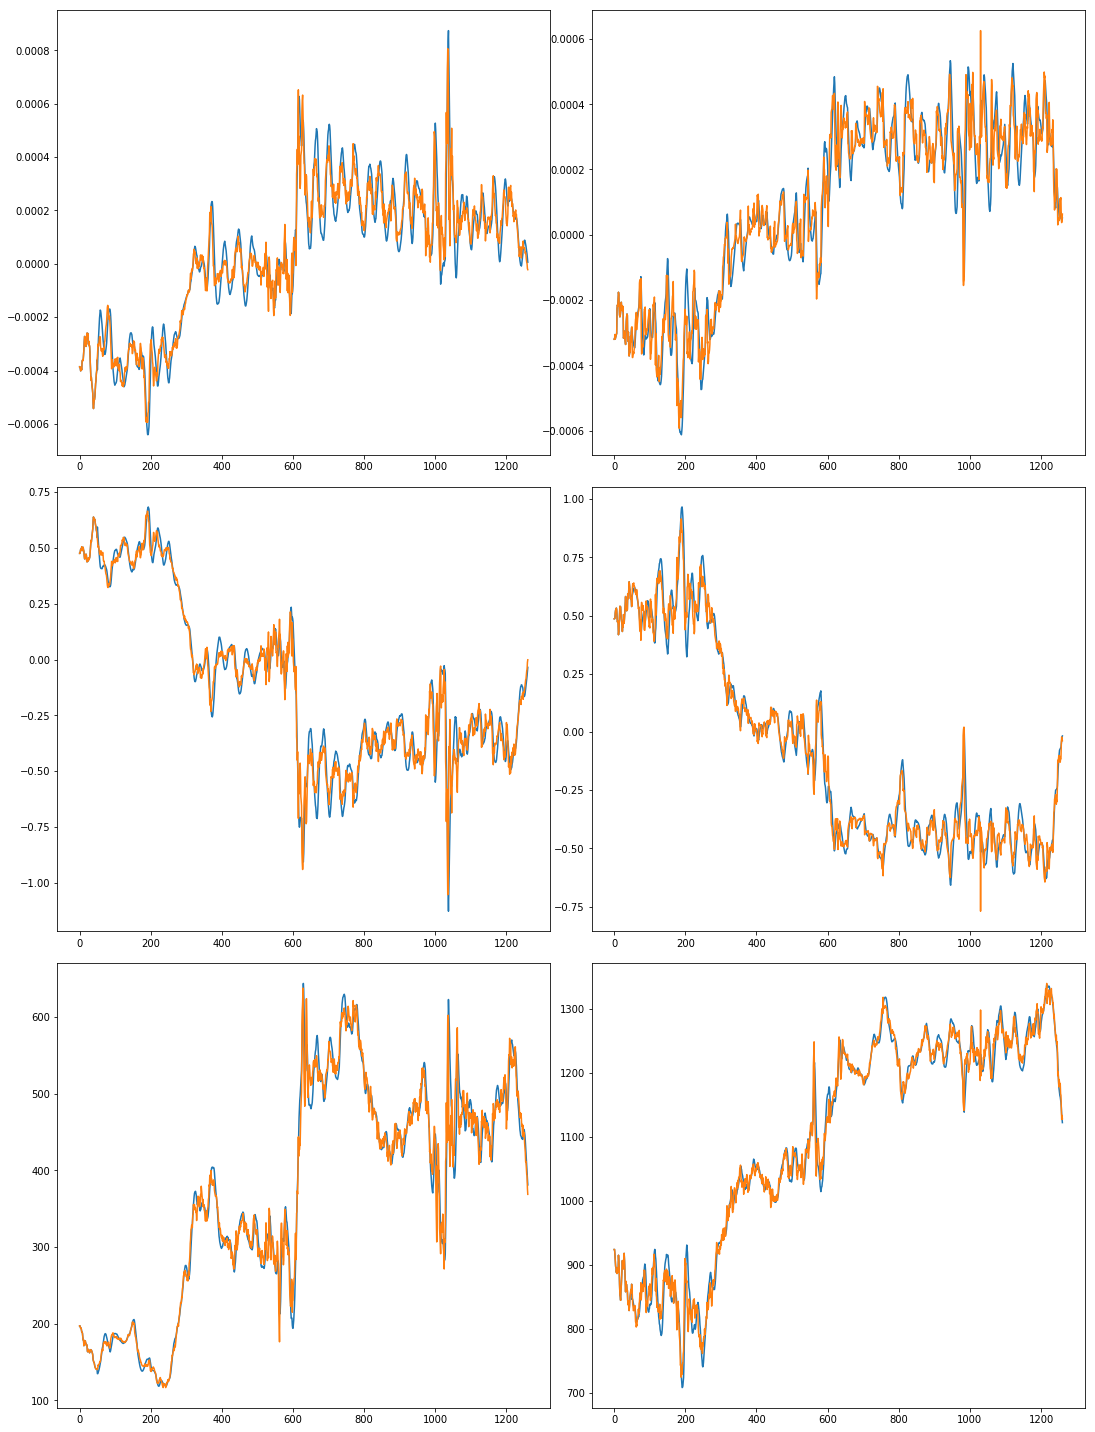

In [121]:
def displaySmoothing(laneFinder):
    fig, axs = plt.subplots(3, 2, figsize=(15, 20))
    fig.tight_layout()

    axs0 = axs[0][0]
    axs0.plot(np.array(laneFinder.left_line.best_fit_history)[:,0])
    axs0.plot(np.array(laneFinder.left_line.current_fit)[:,0])

    axs1 = axs[0][1]
    axs1.plot(np.array(laneFinder.right_line.best_fit_history)[:,0])
    axs1.plot(np.array(laneFinder.right_line.current_fit)[:,0])

    axs2 = axs[1][0]
    axs2.plot(np.array(laneFinder.left_line.best_fit_history)[:,1])
    axs2.plot(np.array(laneFinder.left_line.current_fit)[:,1])

    axs3 = axs[1][1]
    axs3.plot(np.array(laneFinder.right_line.best_fit_history)[:,1])
    axs3.plot(np.array(laneFinder.right_line.current_fit)[:,1])

    axs4 = axs[2][0]
    axs4.plot(np.array(laneFinder.left_line.best_fit_history)[:,2])
    axs4.plot(np.array(laneFinder.left_line.current_fit)[:,2])

    axs5 = axs[2][1]
    axs5.plot(np.array(laneFinder.right_line.best_fit_history)[:,2])
    axs5.plot(np.array(laneFinder.right_line.current_fit)[:,2])
    
displaySmoothing(laneFinder)

In [92]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputVideoName))

In [122]:
inputChallengeVideoClip = VideoFileClip('challenge_video.mp4')
outputChallengeVideoName = 'challenge_video_output.mp4'

laneFinderChallenge = LaneFinder()
#laneFinder.draw_lines = False
laneFinderChallenge.left_line.smoothing_window = 101
laneFinderChallenge.right_line.smoothing_window = 101

outputChallengeVideoClip = inputChallengeVideoClip.fl_image(laneFinderChallenge.process_frame_callback())
%time outputChallengeVideoClip.write_videofile(outputChallengeVideoName, audio=False)

[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4








  0%|          | 0/485 [00:00<?, ?it/s]





  0%|          | 2/485 [00:00<00:43, 11.15it/s]





  1%|          | 4/485 [00:00<00:43, 11.18it/s]





  1%|          | 6/485 [00:00<00:43, 11.03it/s]





  2%|▏         | 8/485 [00:00<00:42, 11.25it/s]





  2%|▏         | 10/485 [00:00<00:42, 11.28it/s]





  2%|▏         | 12/485 [00:01<00:42, 11.26it/s]





  3%|▎         | 14/485 [00:01<00:41, 11.23it/s]





  3%|▎         | 16/485 [00:01<00:41, 11.19it/s]





  4%|▎         | 18/485 [00:01<00:42, 11.10it/s]





  4%|▍         | 20/485 [00:01<00:42, 11.02it/s]





  5%|▍         | 22/485 [00:01<00:42, 11.02it/s]





  5%|▍         | 24/485 [00:02<00:41, 10.99it/s]





  5%|▌         | 26/485 [00:02<00:41, 11.01it/s]





  6%|▌         | 28/485 [00:02<00:41, 10.97it/s]





  6%|▌         | 30/485 [00:02<00:41, 10.93it/s]





  7%|▋         | 32/485 [00:02<00:41, 10.92it/s]





  7%|▋         | 34/485 [00:03<00:41, 10.89it/s]





  7%|▋         | 36/485 [00:03<00:4

 38%|███▊      | 186/485 [00:17<00:28, 10.58it/s]





 39%|███▉      | 188/485 [00:17<00:28, 10.58it/s]





 39%|███▉      | 190/485 [00:17<00:27, 10.60it/s]





 40%|███▉      | 192/485 [00:18<00:27, 10.60it/s]





 40%|████      | 194/485 [00:18<00:27, 10.57it/s]





 40%|████      | 196/485 [00:18<00:27, 10.58it/s]





 41%|████      | 198/485 [00:18<00:27, 10.57it/s]





 41%|████      | 200/485 [00:18<00:27, 10.55it/s]





 41%|████▏     | 201/485 [00:19<00:26, 10.54it/s]





 42%|████▏     | 202/485 [00:19<00:26, 10.53it/s]





 42%|████▏     | 203/485 [00:19<00:26, 10.51it/s]





 42%|████▏     | 204/485 [00:19<00:26, 10.48it/s]





 42%|████▏     | 205/485 [00:19<00:26, 10.48it/s]





 43%|████▎     | 207/485 [00:19<00:26, 10.50it/s]





 43%|████▎     | 209/485 [00:19<00:26, 10.50it/s]





 44%|████▎     | 211/485 [00:20<00:26, 10.51it/s]





 44%|████▍     | 213/485 [00:20<00:25, 10.48it/s]





 44%|████▍     | 214/485 [00:20<00:25, 10.47it/s]





 44%|████▍

 74%|███████▍  | 358/485 [00:35<00:12, 10.19it/s]





 74%|███████▍  | 359/485 [00:35<00:12, 10.18it/s]





 74%|███████▍  | 360/485 [00:35<00:12, 10.17it/s]





 74%|███████▍  | 361/485 [00:35<00:12, 10.16it/s]





 75%|███████▍  | 362/485 [00:35<00:12, 10.16it/s]





 75%|███████▍  | 363/485 [00:35<00:12, 10.15it/s]





 75%|███████▌  | 364/485 [00:35<00:11, 10.14it/s]





 75%|███████▌  | 365/485 [00:35<00:11, 10.14it/s]





 75%|███████▌  | 366/485 [00:36<00:11, 10.14it/s]





 76%|███████▌  | 367/485 [00:36<00:11, 10.12it/s]





 76%|███████▌  | 368/485 [00:36<00:11, 10.12it/s]





 76%|███████▌  | 369/485 [00:36<00:11, 10.11it/s]





 76%|███████▋  | 371/485 [00:36<00:11, 10.11it/s]





 77%|███████▋  | 372/485 [00:36<00:11, 10.10it/s]





 77%|███████▋  | 373/485 [00:36<00:11, 10.10it/s]





 77%|███████▋  | 374/485 [00:37<00:10, 10.09it/s]





 77%|███████▋  | 375/485 [00:37<00:10, 10.09it/s]





 78%|███████▊  | 376/485 [00:37<00:10, 10.09it/s]





 78%|█████

[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

CPU times: user 2min 44s, sys: 19.4 s, total: 3min 3s
Wall time: 50.8 s


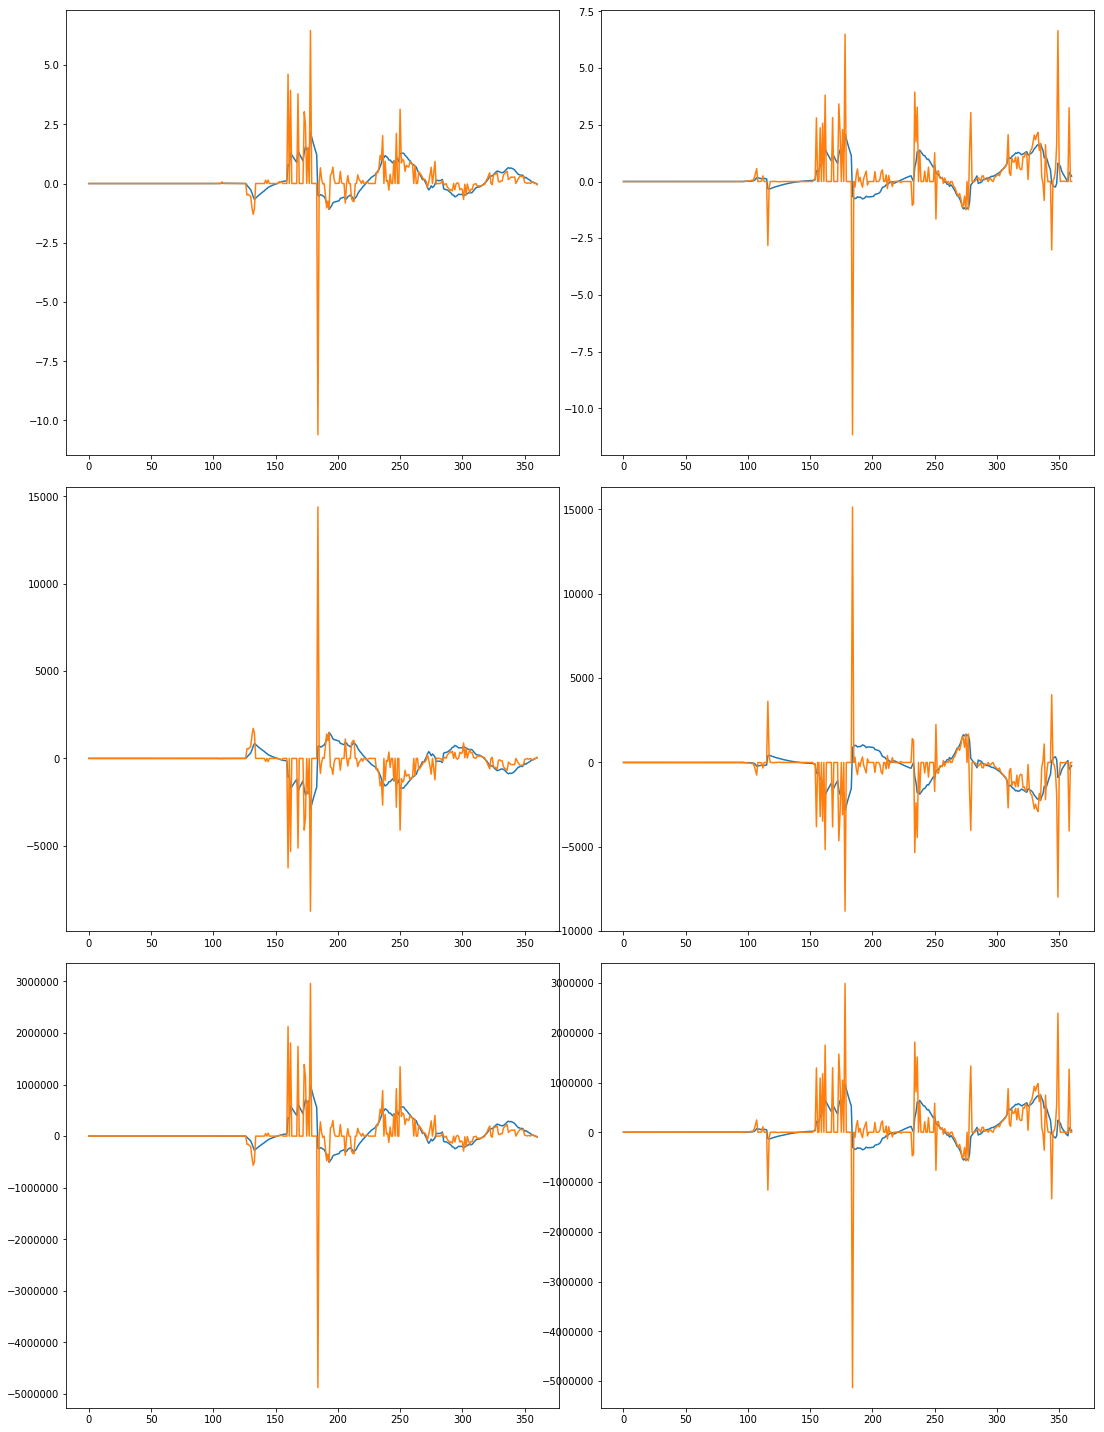

In [123]:
displaySmoothing(laneFinderChallenge)

In [124]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputChallengeVideoName))

In [125]:
inputHarderVideoClip = VideoFileClip('harder_challenge_video.mp4')
outputHarderVideoName = 'harder_challenge_video_output.mp4'

laneFinderHarder = LaneFinder()
laneFinderHarder.left_line.smoothing_window = 101
laneFinderHarder.right_line.smoothing_window = 101
outputHarderVideoClip = inputHarderVideoClip.fl_image(laneFinderHarder.process_frame_callback())
%time outputHarderVideoClip.write_videofile(outputHarderVideoName, audio=False)

[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4








  0%|          | 0/1200 [00:00<?, ?it/s]





  0%|          | 2/1200 [00:00<01:55, 10.41it/s]





  0%|          | 4/1200 [00:00<01:52, 10.61it/s]





  0%|          | 6/1200 [00:00<01:53, 10.56it/s]





  1%|          | 8/1200 [00:00<01:51, 10.65it/s]





  1%|          | 10/1200 [00:00<01:51, 10.67it/s]





  1%|          | 12/1200 [00:01<01:50, 10.73it/s]





  1%|          | 14/1200 [00:01<01:50, 10.75it/s]





  1%|▏         | 16/1200 [00:01<01:49, 10.78it/s]





  2%|▏         | 18/1200 [00:01<01:49, 10.81it/s]





  2%|▏         | 20/1200 [00:01<01:49, 10.82it/s]





  2%|▏         | 22/1200 [00:02<01:49, 10.78it/s]





  2%|▏         | 24/1200 [00:02<01:49, 10.78it/s]





  2%|▏         | 26/1200 [00:02<01:48, 10.80it/s]





  2%|▏         | 28/1200 [00:02<01:49, 10.75it/s]





  2%|▎         | 30/1200 [00:02<01:49, 10.70it/s]





  3%|▎         | 32/1200 [00:02<01:48, 10.73it/s]





  3%|▎         | 34/1200 [00:03<01:49, 10.69it/s]





  3%|▎         | 

 11%|█▏        | 135/1200 [00:15<02:05,  8.47it/s]





 11%|█▏        | 136/1200 [00:16<02:05,  8.45it/s]





 11%|█▏        | 137/1200 [00:16<02:05,  8.44it/s]





 12%|█▏        | 138/1200 [00:16<02:06,  8.42it/s]





 12%|█▏        | 139/1200 [00:16<02:06,  8.41it/s]





 12%|█▏        | 140/1200 [00:16<02:06,  8.41it/s]





 12%|█▏        | 141/1200 [00:16<02:06,  8.40it/s]





 12%|█▏        | 142/1200 [00:16<02:06,  8.39it/s]





 12%|█▏        | 143/1200 [00:17<02:05,  8.39it/s]





 12%|█▏        | 144/1200 [00:17<02:05,  8.38it/s]





 12%|█▏        | 145/1200 [00:17<02:06,  8.37it/s]





 12%|█▏        | 146/1200 [00:17<02:06,  8.36it/s]





 12%|█▏        | 147/1200 [00:17<02:06,  8.35it/s]





 12%|█▏        | 148/1200 [00:17<02:06,  8.34it/s]





 12%|█▏        | 149/1200 [00:17<02:06,  8.33it/s]





 12%|█▎        | 150/1200 [00:18<02:06,  8.33it/s]





 13%|█▎        | 151/1200 [00:18<02:06,  8.32it/s]





 13%|█▎        | 152/1200 [00:18<02:05,  8.32it/

 21%|██        | 250/1200 [00:31<02:01,  7.83it/s]





 21%|██        | 251/1200 [00:32<02:01,  7.83it/s]





 21%|██        | 252/1200 [00:32<02:01,  7.83it/s]





 21%|██        | 253/1200 [00:32<02:00,  7.83it/s]





 21%|██        | 254/1200 [00:32<02:00,  7.83it/s]





 21%|██▏       | 255/1200 [00:32<02:00,  7.83it/s]





 21%|██▏       | 256/1200 [00:32<02:00,  7.82it/s]





 21%|██▏       | 257/1200 [00:32<02:00,  7.82it/s]





 22%|██▏       | 258/1200 [00:33<02:00,  7.82it/s]





 22%|██▏       | 259/1200 [00:33<02:00,  7.82it/s]





 22%|██▏       | 260/1200 [00:33<02:00,  7.82it/s]





 22%|██▏       | 261/1200 [00:33<02:00,  7.82it/s]





 22%|██▏       | 262/1200 [00:33<02:00,  7.81it/s]





 22%|██▏       | 263/1200 [00:33<01:59,  7.81it/s]





 22%|██▏       | 264/1200 [00:33<01:59,  7.81it/s]





 22%|██▏       | 265/1200 [00:33<01:59,  7.81it/s]





 22%|██▏       | 266/1200 [00:34<01:59,  7.81it/s]





 22%|██▏       | 267/1200 [00:34<01:59,  7.81it/

 31%|███       | 367/1200 [00:46<01:45,  7.92it/s]





 31%|███       | 368/1200 [00:46<01:44,  7.92it/s]





 31%|███       | 369/1200 [00:46<01:44,  7.92it/s]





 31%|███       | 370/1200 [00:46<01:44,  7.92it/s]





 31%|███       | 371/1200 [00:46<01:44,  7.92it/s]





 31%|███       | 372/1200 [00:46<01:44,  7.92it/s]





 31%|███       | 373/1200 [00:47<01:44,  7.92it/s]





 31%|███       | 374/1200 [00:47<01:44,  7.91it/s]





 31%|███▏      | 375/1200 [00:47<01:44,  7.91it/s]





 31%|███▏      | 376/1200 [00:47<01:44,  7.91it/s]





 31%|███▏      | 377/1200 [00:47<01:44,  7.90it/s]





 32%|███▏      | 378/1200 [00:47<01:44,  7.90it/s]





 32%|███▏      | 379/1200 [00:48<01:44,  7.89it/s]





 32%|███▏      | 380/1200 [00:48<01:43,  7.89it/s]





 32%|███▏      | 381/1200 [00:48<01:43,  7.88it/s]





 32%|███▏      | 382/1200 [00:48<01:43,  7.87it/s]





 32%|███▏      | 383/1200 [00:48<01:43,  7.87it/s]





 32%|███▏      | 384/1200 [00:48<01:43,  7.86it/

 40%|███▉      | 477/1200 [01:03<01:35,  7.55it/s]





 40%|███▉      | 478/1200 [01:03<01:35,  7.55it/s]





 40%|███▉      | 479/1200 [01:03<01:35,  7.54it/s]





 40%|████      | 480/1200 [01:03<01:35,  7.54it/s]





 40%|████      | 481/1200 [01:03<01:35,  7.54it/s]





 40%|████      | 482/1200 [01:03<01:35,  7.54it/s]





 40%|████      | 483/1200 [01:04<01:35,  7.53it/s]





 40%|████      | 484/1200 [01:04<01:35,  7.53it/s]





 40%|████      | 485/1200 [01:04<01:34,  7.53it/s]





 40%|████      | 486/1200 [01:04<01:34,  7.53it/s]





 41%|████      | 487/1200 [01:04<01:34,  7.53it/s]





 41%|████      | 488/1200 [01:04<01:34,  7.53it/s]





 41%|████      | 489/1200 [01:04<01:34,  7.53it/s]





 41%|████      | 490/1200 [01:05<01:34,  7.53it/s]





 41%|████      | 491/1200 [01:05<01:34,  7.53it/s]





 41%|████      | 492/1200 [01:05<01:34,  7.53it/s]





 41%|████      | 493/1200 [01:05<01:33,  7.53it/s]





 41%|████      | 494/1200 [01:05<01:33,  7.53it/

 50%|████▉     | 597/1200 [01:17<01:18,  7.71it/s]





 50%|████▉     | 599/1200 [01:17<01:17,  7.72it/s]





 50%|█████     | 601/1200 [01:17<01:17,  7.73it/s]





 50%|█████     | 603/1200 [01:17<01:17,  7.74it/s]





 50%|█████     | 605/1200 [01:18<01:16,  7.75it/s]





 51%|█████     | 607/1200 [01:18<01:16,  7.76it/s]





 51%|█████     | 609/1200 [01:18<01:16,  7.77it/s]





 51%|█████     | 611/1200 [01:18<01:15,  7.78it/s]





 51%|█████     | 613/1200 [01:18<01:15,  7.78it/s]





 51%|█████▏    | 615/1200 [01:19<01:15,  7.78it/s]





 51%|█████▏    | 617/1200 [01:19<01:14,  7.78it/s]





 52%|█████▏    | 618/1200 [01:19<01:14,  7.78it/s]





 52%|█████▏    | 619/1200 [01:19<01:14,  7.77it/s]





 52%|█████▏    | 620/1200 [01:19<01:14,  7.77it/s]





 52%|█████▏    | 621/1200 [01:20<01:14,  7.76it/s]





 52%|█████▏    | 622/1200 [01:20<01:14,  7.75it/s]





 52%|█████▏    | 623/1200 [01:20<01:14,  7.75it/s]





 52%|█████▏    | 624/1200 [01:20<01:14,  7.75it/

 60%|██████    | 721/1200 [01:35<01:03,  7.54it/s]





 60%|██████    | 722/1200 [01:35<01:03,  7.54it/s]





 60%|██████    | 723/1200 [01:35<01:03,  7.54it/s]





 60%|██████    | 724/1200 [01:35<01:03,  7.54it/s]





 60%|██████    | 725/1200 [01:36<01:02,  7.54it/s]





 60%|██████    | 726/1200 [01:36<01:02,  7.54it/s]





 61%|██████    | 727/1200 [01:36<01:02,  7.54it/s]





 61%|██████    | 728/1200 [01:36<01:02,  7.54it/s]





 61%|██████    | 729/1200 [01:36<01:02,  7.54it/s]





 61%|██████    | 730/1200 [01:36<01:02,  7.54it/s]





 61%|██████    | 731/1200 [01:36<01:02,  7.54it/s]





 61%|██████    | 732/1200 [01:37<01:02,  7.54it/s]





 61%|██████    | 733/1200 [01:37<01:01,  7.54it/s]





 61%|██████    | 734/1200 [01:37<01:01,  7.54it/s]





 61%|██████▏   | 735/1200 [01:37<01:01,  7.54it/s]





 61%|██████▏   | 736/1200 [01:37<01:01,  7.54it/s]





 61%|██████▏   | 737/1200 [01:37<01:01,  7.54it/s]





 62%|██████▏   | 738/1200 [01:37<01:01,  7.54it/

 69%|██████▉   | 831/1200 [01:51<00:49,  7.47it/s]





 69%|██████▉   | 832/1200 [01:51<00:49,  7.47it/s]





 69%|██████▉   | 833/1200 [01:51<00:49,  7.47it/s]





 70%|██████▉   | 834/1200 [01:51<00:48,  7.47it/s]





 70%|██████▉   | 835/1200 [01:51<00:48,  7.47it/s]





 70%|██████▉   | 836/1200 [01:51<00:48,  7.47it/s]





 70%|██████▉   | 837/1200 [01:52<00:48,  7.47it/s]





 70%|██████▉   | 838/1200 [01:52<00:48,  7.47it/s]





 70%|██████▉   | 839/1200 [01:52<00:48,  7.46it/s]





 70%|███████   | 840/1200 [01:52<00:48,  7.46it/s]





 70%|███████   | 841/1200 [01:52<00:48,  7.46it/s]





 70%|███████   | 842/1200 [01:52<00:47,  7.46it/s]





 70%|███████   | 843/1200 [01:53<00:47,  7.46it/s]





 70%|███████   | 844/1200 [01:53<00:47,  7.45it/s]





 70%|███████   | 845/1200 [01:53<00:47,  7.45it/s]





 70%|███████   | 846/1200 [01:53<00:47,  7.45it/s]





 71%|███████   | 847/1200 [01:53<00:47,  7.45it/s]





 71%|███████   | 848/1200 [01:53<00:47,  7.45it/

 79%|███████▉  | 953/1200 [02:08<00:33,  7.42it/s]





 80%|███████▉  | 955/1200 [02:08<00:33,  7.42it/s]





 80%|███████▉  | 956/1200 [02:08<00:32,  7.42it/s]





 80%|███████▉  | 957/1200 [02:08<00:32,  7.42it/s]





 80%|███████▉  | 958/1200 [02:09<00:32,  7.42it/s]





 80%|███████▉  | 959/1200 [02:09<00:32,  7.42it/s]





 80%|████████  | 960/1200 [02:09<00:32,  7.43it/s]





 80%|████████  | 961/1200 [02:09<00:32,  7.43it/s]





 80%|████████  | 963/1200 [02:09<00:31,  7.43it/s]





 80%|████████  | 964/1200 [02:09<00:31,  7.43it/s]





 80%|████████  | 965/1200 [02:09<00:31,  7.44it/s]





 80%|████████  | 966/1200 [02:09<00:31,  7.44it/s]





 81%|████████  | 967/1200 [02:09<00:31,  7.44it/s]





 81%|████████  | 968/1200 [02:10<00:31,  7.44it/s]





 81%|████████  | 969/1200 [02:10<00:31,  7.44it/s]





 81%|████████  | 970/1200 [02:10<00:30,  7.44it/s]





 81%|████████  | 972/1200 [02:10<00:30,  7.45it/s]





 81%|████████  | 974/1200 [02:10<00:30,  7.45it/

 90%|████████▉ | 1075/1200 [02:24<00:16,  7.43it/s]





 90%|████████▉ | 1076/1200 [02:24<00:16,  7.43it/s]





 90%|████████▉ | 1077/1200 [02:25<00:16,  7.43it/s]





 90%|████████▉ | 1078/1200 [02:25<00:16,  7.43it/s]





 90%|████████▉ | 1079/1200 [02:25<00:16,  7.43it/s]





 90%|█████████ | 1080/1200 [02:25<00:16,  7.43it/s]





 90%|█████████ | 1081/1200 [02:25<00:16,  7.43it/s]





 90%|█████████ | 1082/1200 [02:25<00:15,  7.43it/s]





 90%|█████████ | 1083/1200 [02:25<00:15,  7.43it/s]





 90%|█████████ | 1084/1200 [02:26<00:15,  7.42it/s]





 90%|█████████ | 1085/1200 [02:26<00:15,  7.42it/s]





 90%|█████████ | 1086/1200 [02:26<00:15,  7.42it/s]





 91%|█████████ | 1087/1200 [02:26<00:15,  7.42it/s]





 91%|█████████ | 1088/1200 [02:26<00:15,  7.42it/s]





 91%|█████████ | 1089/1200 [02:26<00:14,  7.42it/s]





 91%|█████████ | 1090/1200 [02:26<00:14,  7.42it/s]





 91%|█████████ | 1091/1200 [02:27<00:14,  7.42it/s]





 91%|█████████ | 1092/1200 [02:

 99%|█████████▊| 1184/1200 [02:42<00:02,  7.29it/s]





 99%|█████████▉| 1185/1200 [02:42<00:02,  7.29it/s]





 99%|█████████▉| 1186/1200 [02:42<00:01,  7.29it/s]





 99%|█████████▉| 1187/1200 [02:42<00:01,  7.29it/s]





 99%|█████████▉| 1188/1200 [02:42<00:01,  7.29it/s]





 99%|█████████▉| 1189/1200 [02:43<00:01,  7.29it/s]





 99%|█████████▉| 1190/1200 [02:43<00:01,  7.29it/s]





 99%|█████████▉| 1191/1200 [02:43<00:01,  7.29it/s]





 99%|█████████▉| 1192/1200 [02:43<00:01,  7.28it/s]





 99%|█████████▉| 1193/1200 [02:43<00:00,  7.28it/s]





100%|█████████▉| 1194/1200 [02:43<00:00,  7.28it/s]





100%|█████████▉| 1195/1200 [02:44<00:00,  7.28it/s]





100%|█████████▉| 1196/1200 [02:44<00:00,  7.28it/s]





100%|█████████▉| 1197/1200 [02:44<00:00,  7.28it/s]





100%|█████████▉| 1198/1200 [02:44<00:00,  7.28it/s]





100%|█████████▉| 1199/1200 [02:44<00:00,  7.28it/s]







[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

CPU times: user 9min 10s, sys: 1min 4s, total: 10min 15s
Wall time: 2min 46s


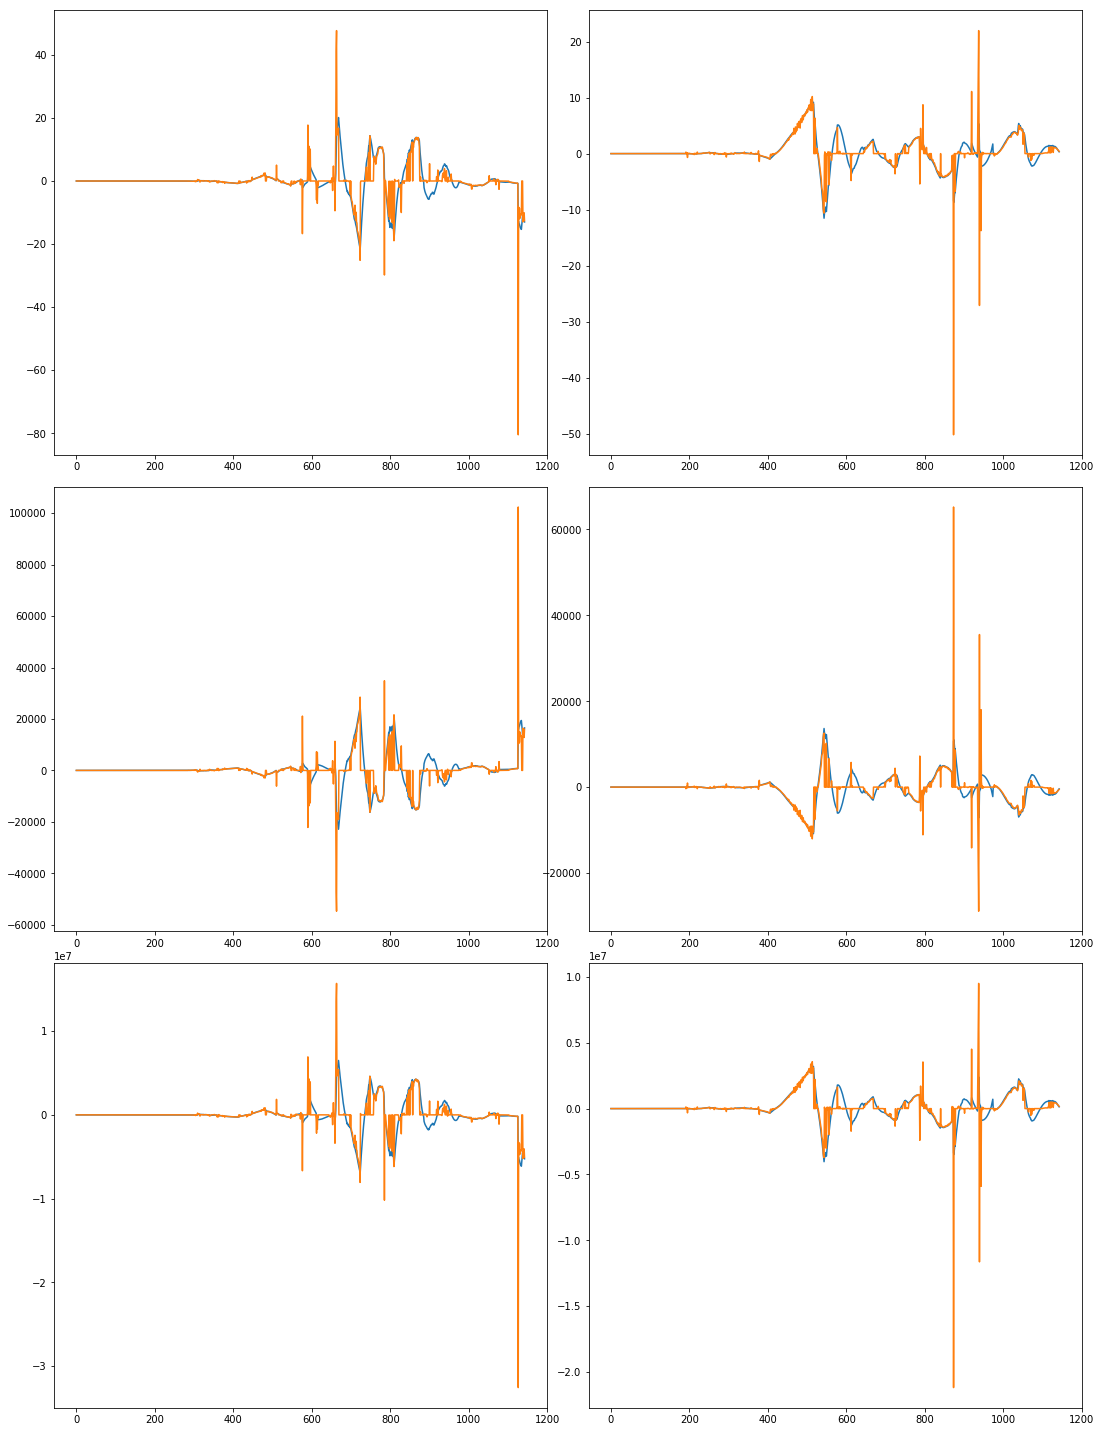

In [126]:
displaySmoothing(laneFinderHarder)

In [127]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(outputHarderVideoName))